In [ ]:
import numpy as np
import pandas as pd

raw_df = pd.read_excel('./data/combined_responses_scores_added.xlsx')
gpt_scores = np.array(raw_df['ChatGPT Percent Score'].dropna())

In [8]:
from scipy import stats

kstest_norm_result = stats.kstest(gpt_scores, stats.norm.cdf)
print(kstest_norm_result)

KstestResult(statistic=np.float64(0.702430986770538), pvalue=np.float64(3.1326399924244043e-83), statistic_location=np.float64(0.62), statistic_sign=np.int8(-1))


In [79]:
class skew_norm_gen(stats.rv_continuous):
    def _argcheck(self, skew):
        return np.isfinite(skew) 
    
    def _pdf(self, x, skew, *args):
        return 2 * stats.norm.pdf(x, *args) * stats.norm.cdf(x * skew, *args)
    
def cap_list_at_one(list):
    new_list = []
    for item in list:
        if item > 1:
            new_list.append(1)
        else:
            new_list.append(item)
    return new_list

In [80]:
skew_norm = skew_norm_gen(name='skew_norm', shapes='skew')

gpt_scores_skew = stats.skew(gpt_scores)
norm_scores = cap_list_at_one(np.random.normal(loc=np.mean(gpt_scores), scale=np.std(gpt_scores), size=len(gpt_scores)))

random_skew_cdf = skew_norm.cdf(norm_scores, skew=gpt_scores_skew)

In [81]:
print(f'Mean: {np.mean(gpt_scores)}')
print(f'StDev: {np.std(gpt_scores)}')
print(f'Skew: {stats.skew(gpt_scores)}')

Mean: 0.8658882235528943
StDev: 0.10496851608442723
Skew: -1.4827595615782678


<Axes: xlabel='ChatGPT Assigned Percent Score', ylabel='Count'>

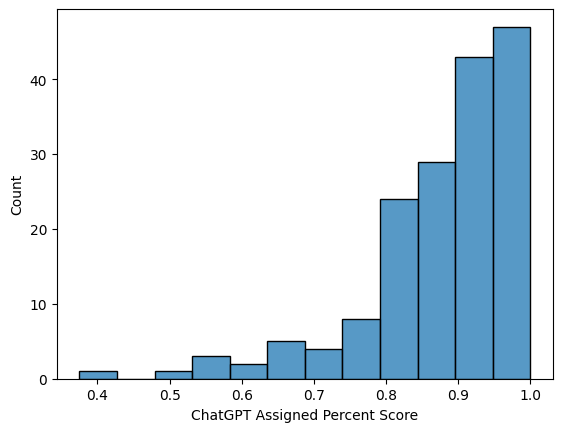

In [7]:
import seaborn as sb
scores_df = pd.DataFrame(gpt_scores, columns=['ChatGPT Assigned Percent Score'])
sb.histplot(scores_df, x='ChatGPT Assigned Percent Score')

In [83]:
def create_skewed_cdf(mean, stdev, size, skew):
    skew_norm = skew_norm_gen(name='skew_norm', shapes='skew')
    norm_scores = cap_list_at_one(np.random.normal(loc=mean, scale=stdev, size=size))
    random_skew_cdf = skew_norm.cdf(norm_scores, skew=skew)
    return random_skew_cdf

In [84]:
gpt_scores_skew = stats.skew(gpt_scores)

list_of_results = []

for mean in np.arange(0.75, 0.95, step=0.01):
    for stdev in np.arange(0.05, 0.25, step=0.01):
        for skew in np.arange(-2, -1, step=0.02):
            temp_skew_cdf = create_skewed_cdf(mean, stdev, len(gpt_scores), skew)
            kstest_skew_result = stats.kstest(gpt_scores, temp_skew_cdf)
            temp_dict = {
                'skew': skew,
                'mean': mean, 
                'stdev': stdev, 
                'pvalue': kstest_skew_result.pvalue
            }
            list_of_results.append(temp_dict)

In [86]:
results_df = pd.DataFrame(list_of_results)
results_df.to_excel('check_results.xlsx')